# Decision Trees for Classification

In this problem, you will implement decision trees for classification on the spam dataset to determine whether or not an email is spam. The data is with the assignment.

## Setup: Imports

We start with importing the relevant packages

In [1]:
from collections import Counter

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

import scipy.io
from scipy import stats
from sklearn.model_selection import train_test_split

import random
random.seed(246810)
np.random.seed(246810)

## Setup: Data Preprocessing

The code to preprocess the data and evaluate the model have been provided for you. While we have provided the code for you, it is important that you read through the code and understand it yourself. In subsequent parts of the assignment, you will need to use the titanic dataset instead of the spam dataset. Make sure to change the dataset when doing those parts of the assignment.

In [2]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) *
                 (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features

def evaluate(dtree, X, y, folds=5, printAccuracies=True):
    if printAccuracies:
        print("Cross Validation:")
    train_accuracies = []
    val_accuracies = []
    for i in range(folds):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)
        dtree.fit(X_train, y_train)
        train_preds = dtree.predict(X_train)
        assert(train_preds.shape == y_train.shape)
        train_accuracy = np.sum(train_preds == y_train) / y_train.shape[0]
        train_accuracies.append(train_accuracy)
        
        val_preds = dtree.predict(X_val)
        assert(val_preds.shape == y_val.shape)
        val_accuracy = np.sum(val_preds == y_val) / y_val.shape[0]
        val_accuracies.append(val_accuracy)
    
    avg_train_accuracy = np.mean(train_accuracies)
    avg_val_accuracy = np.mean(val_accuracies)
    if printAccuracies:
        print('averaged train accuracy:', avg_train_accuracy)
        print('averaged validation accuracy:', avg_val_accuracy)
    return avg_train_accuracy, avg_val_accuracy

In [3]:
eps = 1e-5  # a small number

dataset = "spam"
N = 100

if dataset == "spam":
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
    ]
    assert len(features) == 32

    # Load spam data
    path_train = './datasets/spam_data/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    Z = data['test_data']
    class_names = ["Ham", "Spam"]

else:
    raise NotImplementedError("Dataset %s not handled" % dataset)

print("Features", features)
print("Train/test size", X.shape, Z.shape)

Features ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size (5172, 32) (5857, 32)


## 1) Decision Tree Implementation

Below, we have provided skeleton code for you to implement a basic decision tree. Feel free to use the skeleton code provided, or write the DecisionTree class from scratch if you find that easier.  <b> However, you are not allowed to use any off-the-shelf decision tree implementation. </b>  For instance, you cannot use scipy's entropy function or sklearn's DecisionTreeClassifier. You should only need numpy for your decision tree implementation.

The <b> fit() </b> function should follow the following logic:

    1) Check to make sure that the max_depth of the tree is not reached
    2) If max_depth is reached, then assign this leaf node self.pred and self.leaf_samples
    3) If max_depth is not reached, then:
        a) Find the best feature and corresponding threshold to split the data on
        b) Split the data based on that best feature and threshold
        c) Repeat this for the left and right subtree

In [4]:
eps = 1e-5  # a small number

class DecisionTree:

    def __init__(self, max_depth=3, features=None, min_samples_split=2, X=None, Y=None):
        '''
        This decision tree data structure is a binary tree that is written recursively. In other words, it has a
        left and right branch that themselves are decision trees with the same attributes and methods.
        
        Attributes:
            - self.max_depth (int): Maximum depth of the tree
            - self.features (List of strings): features that are used to make splits in the decision tree (Basically only used in the __repr__ function)
            - self.left (DecisionTree): Left subtree of this decision tree
            - self.right (DecisionTree): Right subtree of this decision tree
            - self.split_feature (int): The index that corresponds to the feature in self.features that was used to 
                                    split this Decision Tree into its left and right branches
            - self.thresh (int): If the value of the split feature is less than self.thresh, the data point will
                                go to the left subtree. Otherwise, it will go to the right subtree
            - self.leaf_samples (int): The number of samples that are classified at a leaf node
            - self.pred (int): The prediction made at a leaf node. Only assigned at a leaf node.
            - self.min_samples_split (int): The 
        '''
        self.max_depth = max_depth
        self.features = features
        self.left, self.right = None, None  # Attributes only for non-leaf nodes
        self.split_feature, self.thresh = None, None  # Attributes only for non-leaf nodes
        self.leaf_samples, self.pred = None, None  # Attributes only for leaf nodes
        self.min_samples_split = min_samples_split

    @staticmethod
    def entropy(y):
        '''
        Calculate the entropy of the tree at the current node. Remember to take care of the special case where we
        must handle log(0), in which case the entropy should be 0!
        
        Inputs:
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            
        Outputs:
            - Entropy: scalar value between 0 and 1
        
        '''
        uniqueClasses = Counter(y)
        n = len(y)
        entropy = 0
        for c in uniqueClasses.keys():
            entropy += (uniqueClasses[c]/n) * (np.log(uniqueClasses[c]/n))
        return -entropy



    def information_gain(self, X_feat, y, thresh):
        '''
        Calculate the information gain from splitting the data based on a specific feature at a specific threshold
        
        Inputs:
            - X_feat: n x 1 vector representing a column of the X data matrix (a single feature)
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            - thresh: The threshold scalar value to split the feature on
        
        Outputs:
            - Information Gain: Scalar value between 0 and 1
        '''
        currentEntropy = DecisionTree.entropy(y)
        y0 = []
        y1 = []
        
        for i in range(len(X_feat)):
            if X_feat[i] < thresh:
                y0.append(y[i])
            else:
                y1.append(y[i])
        
        #conditions where this should be a leaf node
        if len(y0) < self.min_samples_split or len(y1)< self.min_samples_split or self.max_depth == 0:
            self.leaf_samples = len(y)
            #len(y) - sum(y) is the number of zeroes in the t
            self.pred = int(sum(y) >= len(y)/2)
            return 0
        
        entropyLeft = DecisionTree.entropy(y0)
        entropyRight = DecisionTree.entropy(y1)
        
        weightLeft = len(y0)/len(y)
        weightRight = len(y1)/len(y)
        
        return currentEntropy- (weightLeft * entropyLeft + weightRight * entropyRight)
        
        

    
    def feature_split(self, X, y, feature, thresh):
        '''
        Split the data into two halves based on a specific feature at a specific threshold
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            - feature: An index in the range [0, d-1] that represents a specific feature in the data matrix
            - thresh: The threshold scalar value to split the feature on
            
        Outputs:
            - X0: k x d matrix representing the k data points that are split into the left subtree
            - y0: k x 1 vector representing the k class labels that are split into the left subtree
            - X1: (n - k) x d matrix representing the n - k data points that are split into the right subtree
            - y1: (n - k) x 1 vector representing the n - k class labels that are split into the right subtree
        '''
        #0 is left
        x0 = []
        y0 = []
        
        #1 is right
        x1 = []
        y1 = []
        
        
        if feature is not None:
            for i in range(len(X)):
                if X[i, feature] < thresh:
                    x0.append(X[i, :])
                    y0.append(y[i])
                else:
                    x1.append(X[i, :])
                    y1.append(y[i])
        else:
            for i in range(len(X)):
                if X[i] < thresh:
                    x0.append(X[i, :])
                    y0.append(y[i])
                else:
                    x1.append(X[i, :])
                    y1.append(y[i])
        x0 = np.array(x0)
        x1 = np.array(x1)
        y0 = np.array(y0)
        y1 = np.array(y1)
        return x0, y0, x1, y1
    
    def find_feature_thresh(self, X, y, feature):
        '''
        Given the data and the feature, find the best threshold for the feature split. Choose the threshold
        from 10 evenly spaced values between the (min_value + eps) and (max_value - eps) for the feature.
        We need to include the +/- eps for min and max values because without it, there is a chance that the
        training algorithm will split the data on the min or max value, which is not a useful split
        
        Hint: You may find np.linspace helpful
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            - feature: An index in the range [0, d-1] that represents a specific feature in the data matrix
            
        Outputs:
            - max_ig: The largest information gain that is attained
            - best_thresh: The best threshold value that gives us max_ig
        '''
        minX = min(X[:, feature]) + eps
        maxX = max(X[:, feature]) - eps
        numSamples = 10
        space = np.linspace(minX, maxX, num = numSamples)
        max_ig = -1
        best_thresh = None
        for currThresh in space:
            curr_ig = self.information_gain(X[:, feature], y, currThresh)
            if curr_ig > max_ig:
                max_ig = curr_ig
                best_thresh = currThresh
        return max_ig, best_thresh
    
    def find_best_feature_split(self, X, y):
        '''
        Find the best feature and threshold to split on
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            
        Outputs:
            - best_feature: An index in the range [0, d-1] that represents the best feature in the data matrix to split on
            - best_thresh: The best threshold value for best_feature
        '''
        best_feature = None
        best_thresh = None
        best_ig = -float('inf')
        for feature in range(len(X[0])):
            '''print('FEATURE VAL:')
            print(feature)'''
            curr_ig, curr_thresh = self.find_feature_thresh(X, y, feature)
            if curr_ig > best_ig:
                best_ig = curr_ig
                best_feature = feature
                best_thresh = curr_thresh
        return best_feature, best_thresh
                

    def fit(self, X, y):
        '''
        Fit the decision tree
        
        Inputs:
            - X: n x d matrix 
            - y: n x 1 vector of class labels for each data point (either 0 or 1)
            
        Outputs:
            - None
        '''
        self.fit_helper(X, y, self, 0)
            

    def fit_helper(self, X, y, node, i):
        if node.max_depth == 0:
            node.leaf_samples = len(y)
            #len(y) - sum(y) is the number of zeroes in the t
            node.pred = int(sum(y) >= len(y)/2)
            node.max_depth = 0
            return
        
        best_feature, best_thresh = node.find_best_feature_split(X, y)
        
        node.split_feature = best_feature
        node.thresh = best_thresh
        if -1 < best_feature < len(X[0]) and best_thresh:
            x0, y0, x1, y1 = node.feature_split(X, y, best_feature, best_thresh)
            if len(y0) < node.min_samples_split or len(y1)< node.min_samples_split or node.max_depth == 0:
                node.max_depth = 0
                node.leaf_samples = len(y)
            #len(y) - sum(y) is the number of zeroes in the t
                node.pred = int(sum(y) >= len(y)/2)
                return
            else:
                node.left = DecisionTree(max_depth=node.max_depth-1, features=self.features, min_samples_split=node.min_samples_split)
                node.right = DecisionTree(max_depth=node.max_depth-1, features=self.features, min_samples_split=node.min_samples_split)
                #print(x0.shape)
                self.fit_helper(x0, y0, node.left, i+1)
                self.fit_helper(x1, y1, node.right, i+1)
    
    def predict_split(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1
    
    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.predict_split(
                X, idx=self.split_feature, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "[Leaf: %s (%s)]" % (self.pred, self.leaf_samples)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_feature],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())

### Testing your Decision Tree

Now, we will evaluate your decision tree using cross validation with 5 folds. Your decision tree should have a train/validation accuracy that is roughly 76% or higher. We have also included some test cases to ensure that you correctly implemented entropy.

In [5]:
print('==================================================')
print("Entropy Test Cases")

test1 = np.array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

test2 = np.array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1])

test3 = np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

test4 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

''' The first values in the assertions correspond to entropy computed using natural log. 
    The second values correspond to entropy computed using log base 2'''

assert(DecisionTree.entropy(test1) == 0.6913460990017393 or DecisionTree.entropy(test1) == 0.9974015885677396)
print("Test 1 Passed")
assert(DecisionTree.entropy(test2) == 0.6859298002523728 or DecisionTree.entropy(test2) == 0.9895875212220556)
print("Test 2 Passed")
assert(DecisionTree.entropy(test3) == 0.6881388137135884 or DecisionTree.entropy(test3) == 0.9927744539878083)
print("Test 3 Passed")
assert(DecisionTree.entropy(test4) == 0)
print("Test 4 Passed")
assert(DecisionTree.entropy(test4 + 1) == 0)
print("Test 5 Passed")
print("All Test Cases Passed")

Entropy Test Cases
Test 1 Passed
Test 2 Passed
Test 3 Passed
Test 4 Passed
Test 5 Passed
All Test Cases Passed


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [7]:
# Basic decision tree
print('==================================================')
print("\n\nYour decision tree")
dt = DecisionTree(max_depth=3, features=features)
dt.fit(X_train, y_train)
print("Predictions", dt.predict(Z)[:100])
print("Tree structure", dt.__repr__())



Your decision tree
Predictions [0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]
Tree structure [exclamation < 1e-05: [meter < 1e-05: [parenthesis < 1e-05: [Leaf: 0 (1635)] | [Leaf: 0 (953)]] | [Leaf: 0 (549)]] | [ampersand < 1e-05: [meter < 1e-05: [Leaf: 1 (830)] | [Leaf: 0 (48)]] | [out < 1e-05: [Leaf: 0 (76)] | [Leaf: 0 (46)]]]]


In [8]:
print('==================================================')
print("\n\nCross Validation on your decision tree")
print()
evaluate(dt, X, y)



Cross Validation on your decision tree

Cross Validation:
averaged train accuracy: 0.7974377568286197
averaged validation accuracy: 0.7855072463768116


(0.7974377568286197, 0.7855072463768116)

## 2) Tree Depth vs. Performance

Now, we will examine how the depth of our decision tree affects the tree's performance. Train decision trees with depth ranging from 1 to 40. Plot depth on the x axis and train/validation accuracy on the y axis. Comment on your findings in your writeup. Make sure to attach this code to your homework so that we can see your graph!

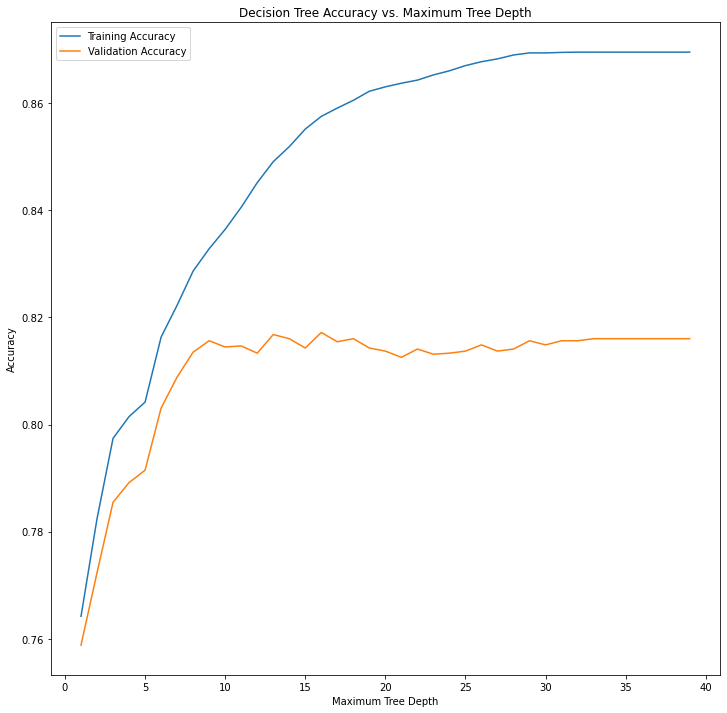

In [9]:
train_accuracy_depth = []
validation_accuracy_depth = []
plt.rcParams["figure.figsize"] = (12,12)
for depth in range(1, 40):
#     ### YOUR CODE HERE ###
    currTree = DecisionTree(max_depth=depth, features=features, min_samples_split=2)
    currTree.fit(X_train, y_train)

    avg_train, avg_val = evaluate(currTree, X, y, printAccuracies=False)
    train_accuracy_depth.append(avg_train)
    validation_accuracy_depth.append(avg_val)
    
# Plot the results here

plt.plot(range(1, 40), train_accuracy_depth, label='Training Accuracy')
plt.plot(range(1, 40), validation_accuracy_depth, label = 'Validation Accuracy')
plt.title('Decision Tree Accuracy vs. Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.legend()

plt.savefig('accuracy_vs_depth.png')

# Study depth and plot